In [2]:
# Read data and aggregate into monthly sale_cnt

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(item_cnt_month=('item_cnt_day','sum')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')
shop_item_list = pd.unique(train_monthly_df['shop_item'])
print("cnt of shop_item:",len(shop_item_list))
train_monthly_df

cnt of shop_item: 424124


,date_block_num,shop_id,item_id,item_cnt_month,shop_item
0,0,0,32,6.0,0-32
1,0,0,33,3.0,0-33
2,0,0,35,1.0,0-35
3,0,0,43,1.0,0-43
4,0,0,51,2.0,0-51
...,...,...,...,...,...
1609119,33,59,22087,6.0,59-22087
1609120,33,59,22088,2.0,59-22088
1609121,33,59,22091,1.0,59-22091
1609122,33,59,22100,1.0,59-22100


In [3]:
# get the sequence of each shop_item

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    data_seq_dict[shop_item] = [0.0 for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])] = row['item_cnt_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print(data_seq_array)
print(data_seq_array.shape)

[[ 6. 10.  0. ...  0.  0.  0.]
 [ 3.  3.  0. ...  0.  0.  0.]
 [ 1. 14.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  0.  1.]]
(424124, 34)


In [4]:
# get the default sequence for items: calculate the average sale_cnt as default sequence for items

item_seq_dict = {}
item_seq_num_dict = {}
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = item_seq_dict[item] + v
        item_seq_num_dict[item] += 1
for item in item_seq_dict.keys():
    item_seq_dict[item] = [e / item_seq_num_dict[item] for e in item_seq_dict[item]]

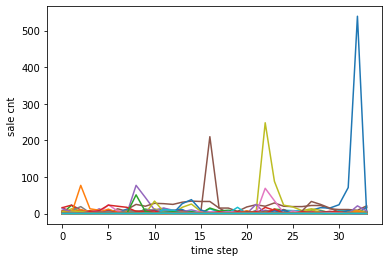

In [21]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(data_seq_array.shape[0])
np.random.shuffle(row_random_array)
row_random = data_seq_array[row_random_array[0:100]]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [51]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

X = data_seq_array[:,0:-1]
Y = data_seq_array[:,1:]
X = X.reshape((X.shape[0], X.shape[1], 1))
Y = Y.reshape((Y.shape[0], Y.shape[1], 1))
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
# Normalize X_train
X_train_mean = X_train.mean(axis=1)
X_train_var = X_train.var(axis=1)
X_train = (X_train-X_train_mean.reshape((X_train_mean.shape[0],1,1)))/(X_train_var.reshape((X_train_mean.shape[0],1,1))+K.epsilon())
# Normalize X_val
X_val_mean = X_val.mean(axis=1)
X_val_var = X_val.var(axis=1)
X_val = (X_val-X_val_mean.reshape((X_val_mean.shape[0],1,1)))/(X_val_var.reshape((X_val_mean.shape[0],1,1))+K.epsilon())
# Normalize Y_train
Y_train_mean = Y_train.mean(axis=1)
Y_train_var = Y_train.var(axis=1)
Y_train = (Y_train-Y_train_mean.reshape((Y_train_mean.shape[0],1,1)))/(Y_train_var.reshape((Y_train_mean.shape[0],1,1))+K.epsilon())
# Normalize Y_val
Y_val_mean = Y_val.mean(axis=1)
Y_val_var = Y_val.var(axis=1)
Y_val = (Y_val-Y_val_mean.reshape((Y_val_mean.shape[0],1,1)))/(Y_val_var.reshape((Y_val_mean.shape[0],1,1))+K.epsilon())

In [13]:
# DeepAR

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Lambda, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

def gaussian_likelihood(y_pred, y_true):
    mean = tf.slice(y_pred, [0,0], [-1,1])
    stddev = tf.slice(y_pred, [0,1], [-1,1])
    return tf.reduce_sum(tfp.distributions.Normal(loc=mean, scale=stddev).log_prob(y_true))

def negbin_likelihood(y_pred, y_true):
    mean = tf.slice(y_pred, [0,0], [-1,1])
    alpha = tf.slice(y_pred, [0,1], [-1,1])
    return tf.reduce_sum(tfp.distributions.NegativeBinomial(total_count=1/alpha, probs=1/(1+tf.multiply(mean,alpha))).log_prob(y_true))

# model
# LSTM encoder+decoder
input_encoder_vec = Input(name='input', shape = (X_train.shape[1], X_train.shape[2]))
lstm_vec = LSTM(1, return_sequences=False, name='encoder1')(input_encoder_vec)
# likelihood distribution
# Gaussian
mean_vec = Dense(1)(lstm_vec)
theta_vec = Dense(1, activation='softplus')(lstm_vec)
# Negative binomial
# mean_vec = Dense(1, activation='softplus')(lstm_vec)
# theta_vec = Dense(1, activation='softplus')(lstm_vec)
output_vec = Concatenate(axis=1)([mean_vec, theta_vec])
output_vec = Reshape((2,))(output_vec)

model = Model(inputs=[input_encoder_vec], outputs=[output_vec])
model.compile(loss=gaussian_likelihood, optimizer=Adam(learning_rate=0.001))
model.summary()

model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=1024*256)

2022-11-16 08:39:40.138074: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 33, 1)]      0                                            
__________________________________________________________________________________________________
encoder1 (LSTM)                 (None, 1)            12          input[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            2           encoder1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            2           encoder1[0][0]                   
______________________________________________________________________________________________

2022-11-16 08:39:40.731535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2/2 [==============================] - 5s 958ms/step - loss: nan - val_loss: nan
Epoch 2/10
2/2 [==============================] - 1s 327ms/step - loss: nan - val_loss: nan
Epoch 3/10
2/2 [==============================] - 1s 328ms/step - loss: nan - val_loss: nan
Epoch 4/10
2/2 [==============================] - 1s 321ms/step - loss: nan - val_loss: nan
Epoch 5/10
2/2 [==============================] - 1s 324ms/step - loss: nan - val_loss: nan
Epoch 6/10


KeyboardInterrupt: 

In [ ]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    if shop_item in data_seq_dict.keys():
        X_test.append(data_seq_dict[shop_item])
    elif row['item_id'] in item_seq_dict.keys():
        X_test.append(item_seq_dict[row['item_id']])
        print(row['item_id'])
    else:
        X_test.append([0.0 for i in range(0,34)])
X_test = np.asarray(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test = X_test[:,1:,:]

In [ ]:
pred = model.predict(X_test)

pred = pred[:,-1:,:]
pred = pred.reshape((pred.shape[0]))

In [ ]:
submission_df = pd.DataFrame(pred, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

In [ ]:
submission_df.to_csv('/kaggle/working/submission.csv')